In [1]:
import os
import torch
import torchvision
from tqdm.notebook import tqdm 
from sklearn import metrics
import numpy as np 

from dataset.nih_xnet_dataset_feb3 import get_datasets
from abnormality_mask_attention_8432.models.model6 import DesnseNet121

import torch.nn as nn

torch.manual_seed(41)

# Dataset and Dataloader 

In [2]:
import json
from easydict import EasyDict as edict

config = None
with open('./config/example.json') as f:
    config = edict(json.load(f))

In [3]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([transforms.ToPILImage(), 
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    normalize])

In [4]:
# dataset_train = XRaysTrainDataset('/home/mhealth-14/Thesis_400_CXR/iqbal/codebase/HAM/NIH_dataset', transform=transform)
# dataset_test = XRaysTestDataset('/home/mhealth-14/Thesis_400_CXR/iqbal/codebase/HAM/NIH_dataset', transform=transform)

In [5]:
_, _, dataset_test = get_datasets()

# Model Define

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DesnseNet121(num_classes=15)
model = model.to(device)
'''
with torch.no_grad():
    # class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))
    class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))
'''

"\nwith torch.no_grad():\n    # class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))\n    class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))\n"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

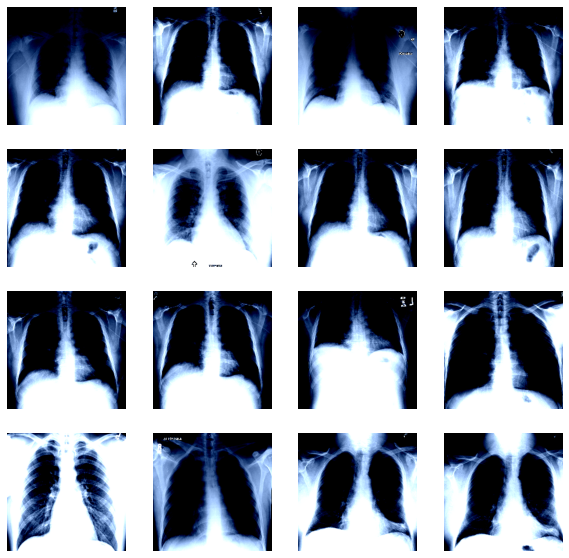

In [7]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,10))
dataiter = iter(dataset_test)

for i in range(16):
    img, _, _, _ = next(dataiter)
    # img = cfg.pixel_std * img + cfg.pixel_mean
    plt.subplot(4,4,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
plt.show()

# Train-Test Functions

In [8]:
@torch.no_grad()
def test():
    model.eval()
    predlist = [[] for i in range(num_diseases)]
    truelist = [[] for i in range(num_diseases)]
    loss_list = []

    for images, abnorm_masks, lung_mask, class_label_gts in testloader:
        images = images.to(device)
        lung_mask = lung_mask.to(device)
        abnorm_masks = abnorm_masks.to(device)
        class_label_gts = class_label_gts.to(device)
        
        # images = images * lung_mask
        # abnorm_masks[:, 3, :, :] = lung_mask[:, 0, :, :]
        #class_label_preds, _ = model(images, abnorm_masks)
        class_label_preds, _ = model(images, abnorm_masks, lung_mask)
        loss = loss_function(class_label_preds, class_label_gts)
        loss_list .append(loss.item())
        
        for i in range(num_diseases):
            pred = torch.sigmoid(class_label_preds[:,i]).cpu().detach().numpy()
            predlist[i] = np.append(predlist[i], pred)
            truelist[i] = np.append(truelist[i], class_label_gts[:,i].cpu().detach().numpy())
            
    predlist = np.array(predlist)
    truelist = np.array(truelist)
    loss_list = np.array(loss_list)
    loss_list = loss_list.mean()

    auclist = []
    acclist = []

    for i in range(num_diseases):
        y_pred = predlist[i]
        y_true = truelist[i]
                    
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label = 1)
        auc = metrics.auc(fpr, tpr)
        auclist.append(auc)
        acc = metrics.accuracy_score(y_true,y_pred>0.5)
        acclist.append(acc)
    auc_mean = np.array(auclist).mean()
    acc_mean = np.array(acclist).mean()
            
    model.train()


    print("Auc:",auclist,"  auc mean: ", auc_mean)
    print("Loss mean", loss_list)
    return auclist, auc_mean, acc_mean, loss_list.sum()

# Training Parameters

In [9]:
batch_size = 1
num_diseases = 14
resume = False

In [10]:
testloader = torch.utils.data.DataLoader(
                    dataset_test, batch_size=batch_size,
                    drop_last = True)

In [11]:
loss_function = nn.BCEWithLogitsLoss()

# Training Phase

In [12]:
from eval import show_overlayed_heatmap, process_heatmap, process_image

In [13]:
model= torch.load("./best.ckpt")['model']
model.eval()

DesnseNet121(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [14]:
auclist, auc_mean, acc_mean, loss = test()

Auc: [0.8234699614671952, 0.9141226089033805, 0.8837174338769052, 0.7046845804481493, 0.8548810752126765, 0.7873210375834833, 0.7719200435289268, 0.8762617227887434, 0.8051712314570293, 0.8893375601753192, 0.9210618285206728, 0.8271973097369588, 0.7848410372632347, 0.8974215830765336]   auc mean:  0.8386720724313721
Loss mean 0.1757622414955701


In [17]:
acc_mean

0.947430762078825

In [16]:
a, b, c, d = next(iter(testloader))

In [18]:
a.shape, b.shape, c.shape, d.shape

(torch.Size([1, 3, 224, 224]),
 torch.Size([1, 15, 224, 224]),
 torch.Size([1, 1, 224, 224]),
 torch.Size([1, 15]))

In [19]:
idx = 444
itr = iter(testloader)

for i in range(idx):
    image, abnorm_mask, _, label = next(itr)
    
with torch.no_grad():
    image = image.to(device)
    abnorm_mask = abnorm_mask.to(device)
    pred, heatmap = model(image, abnorm_mask)
processesd_image = process_image(image[0])
processed_heatmap = process_heatmap(heatmap[0])

KeyboardInterrupt: 

/home/mhealth-14/Thesis_400_CXR/iqbal/codebase/Ham_jawwad/CXR-bangla/eval.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bbox_list = np.array(bbox_list)


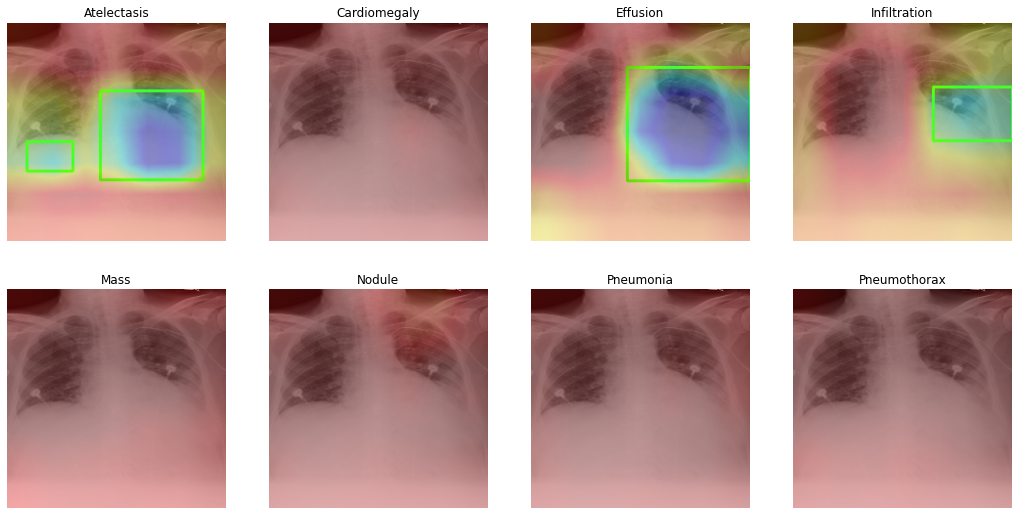

In [ ]:
show_overlayed_heatmap(processesd_image, processed_heatmap, mode=3)